# **<span style="color:Black;">Clustering Notebook</span>**

## **Purpose of Notebook**
Loading the dataset, sampling and encoding the dataset for clustering, experimenting with kmeans hyperparameters and optimial k for clustering (elbow method), evlauting using silohuette score, plotting PCA and TSNE diagrams with decision trees for explainabilty and clusterlabelling

---

## **Contents of notebook**
### **Section 1: Loading, Sampling and Encoding the Dataset**
```python 
- [x] Loading the cleaned datasets
- [x] statified sample the data (uk)
- [x] Prepare, encode, scale, SMOTE,
- [x] Classifcation and Confusion matrix function

**Import Neccessary Libraries**

In [66]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import ParameterSampler
from scipy.stats import randint, uniform
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
sns.set(style="whitegrid")
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



## **<span style="color:blue;">Section 1: Loading Datasets and sampling</span>**

**Load Datasets**

In [32]:
UK_full = pd.read_csv("/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/UK-cleaned_data.csv")
US_full = pd.read_csv("/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/US_imputed_data.csv")

# Dropping index and Unrequired columns
UK_full.drop(columns=['latitude', 'longitude', 'Report ID', 'Report Version'], inplace=True, errors='ignore')
US_full.drop(columns=['Report ID', 'Report Version'], inplace=True, errors='ignore')
print("Shape UK:", UK_full.shape)
print("Shape US:", US_full.shape)

Shape UK: (229782, 19)
Shape US: (4032, 19)


**Sample UK dataset**

In [33]:
def stratified_sample(data, sample_frac=0.4, stratify_col='Highest Injury Severity Alleged'):
    """
    Process: Statfied sample on data to ensure severity minority is correctly distributed
    Reference:
    - how to pass in column for splitting: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
    - how to split the data for statifying https://datascience.stackexchange.com/questions/45174/how-to-use-sklearn-train-test-split-to-stratify-data-for-multi-label-classificat
    - random select sample element(lodash_.) https://www.geeksforgeeks.org/javascript/lodash-_-sample-method/
    """
    if stratify_col not in data.columns:
        possible = data.select_dtypes(include=['object','category']).columns
        stratify_col = possible[0]
    _, sample = train_test_split( # splitting the sampled data
        data,
        test_size=sample_frac, # how much data we want (40%)
        stratify=data[stratify_col],
        random_state=42
    )
    # print results
    print("Original distribution of Severity):")
    print(data[stratify_col].value_counts(normalize=True).head(3))
    print("\nSample distribution of Severity:")
    print(sample[stratify_col].value_counts(normalize=True).head(3))
    return sample

# call function
UK_sampled= stratified_sample(UK_full, sample_frac=0.1) # 40% sample
print("UK sampled shape:", UK_sampled.shape)


Original distribution of Severity):
Highest Injury Severity Alleged
Minor       0.774512
Serious     0.210086
Fatality    0.015402
Name: proportion, dtype: float64

Sample distribution of Severity:
Highest Injury Severity Alleged
Minor       0.774490
Serious     0.210105
Fatality    0.015405
Name: proportion, dtype: float64
UK sampled shape: (22979, 19)


**Encode the datasets**

In [34]:
UK_sampled.head()
UK_sampled.nunique()

Make                                 50
Model                               483
Model Year                           43
ADS Equipped?                         1
Automation System Engaged?            1
Incident Date                      1825
Incident Time (24:00)              1396
City                               3504
State                                 4
Roadway Type                          5
Roadway Surface                       4
Posted Speed Limit (MPH)              6
Lighting                              5
Crash With                           12
Highest Injury Severity Alleged       3
SV Pre-Crash Movement                17
Weather                               7
SV Contact Area                       5
Country                               2
dtype: int64

In [35]:
US_full.head()
US_full.nunique()

Make                                 54
Model                               150
Model Year                           13
ADS Equipped?                         2
Automation System Engaged?            2
Incident Date                        99
Incident Time (24:00)              1310
City                               1299
State                                51
Roadway Type                          7
Roadway Surface                       4
Posted Speed Limit (MPH)              9
Lighting                              5
Crash With                           15
Highest Injury Severity Alleged       5
SV Pre-Crash Movement                16
Weather                              16
SV Contact Area                      43
Country                               1
dtype: int64

## **<span style="color:blue;">Section 2: Encoding the datasets</span>**

In [36]:

def prepare_for_clustering(data, high_card_threshold=20): # if more than 20 catergorical then freq map
    """
    Process: Encodes and scales the data based on the cardinality (more efficent)
    - high cardinality = frequency encoding
    - low cardinality = ordinal
    - numerical =  scale
    Reference:
    - seperating the categorical columns https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.select_dtypes.html
    - frequency encoding https://letsdatascience.com/frequency-encoding/
    - https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html
    """
    data = data.copy() # create a copy
    
    # Separate categorical columns
    cat_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
    high_card_cols = [col for col in cat_cols if data[col].nunique() > high_card_threshold]
    low_card_cols = [col for col in cat_cols if data[col].nunique() <= high_card_threshold]
    
    # Frequency encode high cardinality cols
    for col in high_card_cols:
        freq_map = data[col].value_counts(normalize=True)  # normalized freq
        data[col] = data[col].map(freq_map).fillna(0)
    
    # Ordinal encode low cardinality cols
    if low_card_cols:
        oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        data[low_card_cols] = oe.fit_transform(data[low_card_cols])
    
    # Scale all numeric features (including encoded categories)
    scaler = StandardScaler()
    data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
    
    return data_scaled, scaler




In [38]:
us_encoded, preprocessor = prepare_for_clustering(US_full)
print(us_encoded.head())


       Make     Model  Model Year  ADS Equipped?  Automation System Engaged?  \
0 -1.720367 -1.729962    0.690496      -0.876596                    -0.87174   
1 -1.720367 -1.729962   -0.740172      -0.876596                    -0.87174   
2 -1.720367 -1.729962    0.213607      -0.876596                    -0.87174   
3 -1.720367 -1.729962    0.690496      -0.876596                    -0.87174   
4 -1.720367 -1.729962   -1.217061      -0.876596                    -0.87174   

   Incident Date  Incident Time (24:00)      City     State  Roadway Type  \
0       1.111455              -0.542034 -0.633572 -1.142907     -0.972877   
1      -0.584558              -0.542034 -0.633572 -0.673354     -0.972877   
2       0.328680               0.892009 -0.616845  1.058932     -0.972877   
3       0.502630               0.413995 -0.633572 -1.107603     -0.972877   
4      -1.758720              -0.542034 -0.538790 -0.913426     -0.972877   

   Roadway Surface  Posted Speed Limit (MPH)  Lighting  

In [40]:
uk_encoded, preprocessor = prepare_for_clustering(UK_sampled)
print(uk_encoded.head())

            Make     Model  Model Year  ADS Equipped?  \
66304  -0.516497 -0.845888   -0.150441            0.0   
20382  -0.148676 -0.663231   -0.695475            0.0   
170970  1.334299  1.390951   -0.332119            0.0   
27415  -0.353848  0.011192   -0.513797            0.0   
14123   0.679451 -0.834647    0.757951            0.0   

        Automation System Engaged?  Incident Date  Incident Time (24:00)  \
66304                          0.0      -1.753299              -0.730627   
20382                          0.0      -1.128362              -0.815730   
170970                         0.0      -2.169923              -0.900832   
27415                          0.0       1.579698              -0.645525   
14123                          0.0       0.329824               0.077845   

            City     State  Roadway Type  Roadway Surface  \
66304   1.616359 -0.300646      0.477850        -0.647292   
20382   1.756096 -0.300646     -0.420719         1.575381   
170970 -0.572853 

## **<span style="color:blue;">Section 3: Kmeans and Tuning</span>**

**Finding the best Hyperparameters - RandomSearch CV**

In [41]:
def random_kmeans_search(X, n_iter=15, show_progress=False):
    """
    Process: Random Search for hyperparamters found in Lit Review to find best siloheuette score
    Reference:
    - grid to store paramters: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html
    - kmeans running https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
    - tqdm for timing: https://www.datacamp.com/tutorial/tqdm-python
    """
    # hyperparameters
    param_grid = {
        "n_init": [10, 15, 20],
        "max_iter": [300, 400, 500],
        "init": ["k-means++", "random"]
    }
    best_score = -1 # set to -1 as initialised
    best_params = None 
    # to check how long it will take
    iterator = tqdm(range(n_iter), desc="Random Search", unit="iter") if show_progress else range(n_iter)
    
    # iterate random choices underscore method
    for _ in iterator:
        params = {
            "n_init": np.random.choice(param_grid["n_init"]),
            "max_iter": np.random.choice(param_grid["max_iter"]),
            "init": np.random.choice(param_grid["init"])
        }
        # apply to k means and if better than last then store as best score
        kmeans = KMeans(n_clusters=3, random_state=42, **params)  # default k for search
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        
        if score > best_score:
            best_score = score
            best_params = params
    print(best_params)
    return best_params, best_score

**Plotting Elbow and Silohuette Score**

In [42]:

def elbow_and_silhouette(X, k_min=2, k_max=10):
    """
    Process: Running Kmeans for all the clusters and the finding the interia and silo score
    Reference: 
    - elbow method:https://www.geeksforgeeks.org/machine-learning/elbow-method-for-optimal-value-of-k-in-kmeans/
    - double line plot: https://www.geeksforgeeks.org/python/plot-multiple-lines-in-matplotlib/
    """
    inertia = []
    sil_scores = []
    
    for k in range(k_min, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)  # Elbow method metric
        sil_scores.append(silhouette_score(X, kmeans.labels_))  # Silhouette score
    
    # Plotting both on the same chart
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    ax1.plot(range(k_min, k_max+1), inertia, 'bo-', label='inertia')
    ax2.plot(range(k_min, k_max+1), sil_scores, 'ro-', label='Silhouette')
    
    ax1.set_xlabel('Number of clusters (k)')
    ax1.set_ylabel('Inertia (Elbow)', color='b')
    ax2.set_ylabel('Silhouette Score', color='r')
    plt.title("Elbow & Silhouette Analysis")
    plt.show()
    
    optimal_k = sil_scores.index(max(sil_scores)) + k_min
    print(f"Best k by silhouette: {optimal_k}")
    return optimal_k


**Running the hyperparameter and plots for each dataset **

In [ ]:

def run_kmeans_workflow(X, dataset_name):
    """
    Process: Runs hyperparameter, uses them, then plots the silohuette and Inertia scores
    """
    optimal_k = elbow_and_silhouette(X) # run function
    # as 2 returns given easy way to say it
    best_params, best_score = random_kmeans_search(X, n_iter=15, show_progress=True)

    best_params['n_clusters'] = optimal_k
    kmeans = KMeans(random_state=42, **best_params)
    labels = kmeans.fit_predict(X)
    sil = silhouette_score(X, labels)
    print(f"Final silhouette score for {dataset_name}: {sil:.3f}")
    
    return kmeans, labels


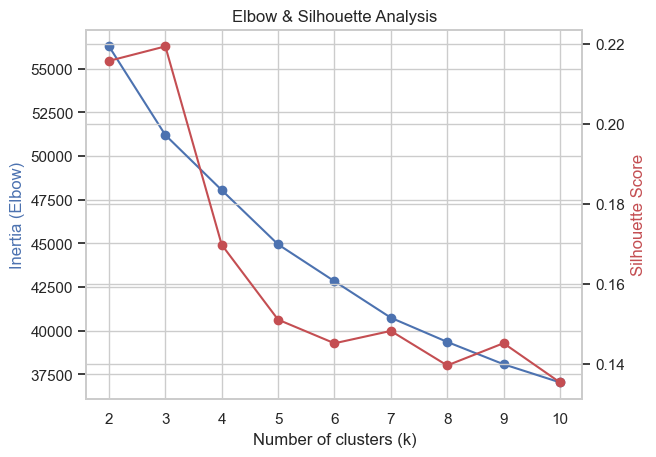

Best k by silhouette: 3


Random Search: 100%|██████████| 15/15 [00:06<00:00,  2.16iter/s]


{'n_init': 10, 'max_iter': 400, 'init': 'random'}
Final silhouette score for US Dataset: 0.219


In [44]:
# US dataset
us_model, us_labels = run_kmeans_workflow(us_encoded, "US Dataset")

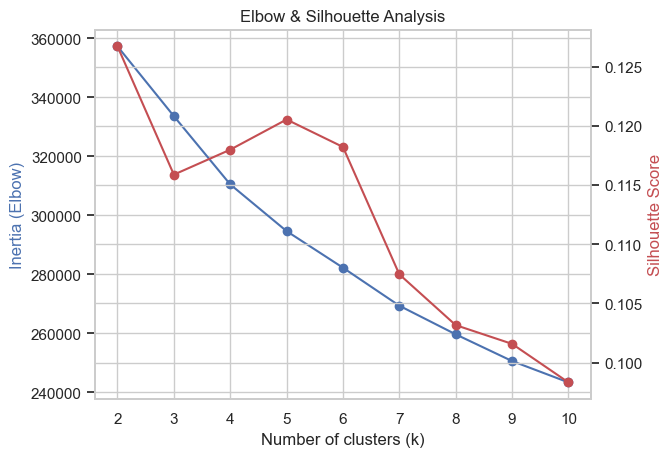

Best k by silhouette: 2


Random Search: 100%|██████████| 15/15 [01:31<00:00,  6.07s/iter]


{'n_init': 10, 'max_iter': 400, 'init': 'random'}
Final silhouette score for UK Dataset: 0.127


In [45]:
# UK dataset
uk_model, uk_labels = run_kmeans_workflow(uk_encoded, "UK Dataset")

## **<span style="color:blue;">Section 2: Running KMeans + Explainablty</span>**

**Running K-means + Decision Tree**

In [63]:
def run_kmeans_with_explainability(X, dataset_name, params, run_decision_tree=True, plot_tree_flag=True):
    """
    Process: Runs KMeans with given params, evaluates with silhouette score, trains and plots a decision tree
            with pastel colors for cluster explainability.
    Reference:
    - decsion tree explainabilty: https://www.datacamp.com/tutorial/explainable-ai-understanding-and-trusting-machine-learning-models
    - zip dict: https://realpython.com/python-zip-function/
    - tree plot: https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html
    - colour and tree plot: https://www.geeksforgeeks.org/machine-learning/changing-colors-for-decision-tree-plot-using-sklearn-plot-tree/
    - the features most important: https://stackoverflow.com/questions/69061767/how-to-plot-feature-importance-for-decisiontreeclassifier
    - getting the object from class (https://www.w3schools.com/python/ref_func_getattr.asp
    """
    print(f"Best Parameters: {params}")

    # Run the kmeans with the best params and train superivsed decsion tree
    kmeans = KMeans(random_state=42, **params)
    labels = kmeans.fit_predict(X)
    sil = silhouette_score(X, labels)
    unique, counts = np.unique(labels, return_counts=True)
    cluster_counts = dict(zip(unique, counts)) # store results in dict

    # just to also check if matches with the cell results above
    print(f"Silhouette Score: {sil:.3f}") # 
    print(f"Cluster Counts: {cluster_counts}")

    # Decision tree for explainability
    if run_decision_tree: 
        print("\nTraining Decision Tree for Explainability...")
        dt = DecisionTreeClassifier(random_state=42, max_depth=4) # DEPTH!!! HOW many levels down
        dt.fit(X, labels)         # Train the decision tree
        if hasattr(X, "columns"):  # get name of each feature and add to list
            feat_names = list(X.columns)

        # Get feature importance values
        importances = dt.feature_importances_

        # Print features sorted by importance
        print("\nFeature Importances:")
        sorted_features = sorted(zip(feat_names, importances), key=lambda x: x[1], reverse=True)
        for feature, importance in sorted_features:
            print(f"{feature}: {importance:.4f}")


        # plotting to make as easy to see as possible
        if plot_tree_flag:
            plt.figure(figsize=(20,10))
            plot_tree(
                dt,
                feature_names=feat_names,
                class_names=[str(col) for col in np.unique(labels)],
                filled=True,
                rounded=True,
                fontsize=16,
                impurity=False,
                proportion=True,
            )
            plt.title(f"Decision Tree - {dataset_name}", fontsize=20)
            plt.tight_layout()
            plt.show()

    return {"model": kmeans, "labels": labels, "silhouette": sil, "cluster_counts": cluster_counts}


**Final Cluster Run of US data**

Best Parameters: {'n_clusters': 3, 'init': 'k-means++', 'max_iter': 500, 'n_init': 15}
Silhouette Score: 0.219
Cluster Counts: {0: 389, 1: 1969, 2: 1674}

Training Decision Tree for Explainability...

Feature Importances:
ADS Equipped?: 0.7058
Roadway Surface: 0.2339
Weather: 0.0547
City: 0.0026
Automation System Engaged?: 0.0015
Model: 0.0012
Incident Date: 0.0001
Posted Speed Limit (MPH): 0.0001
Make: 0.0001
Model Year: 0.0000
Incident Time (24:00): 0.0000
State: 0.0000
Roadway Type: 0.0000
Lighting: 0.0000
Crash With: 0.0000
Highest Injury Severity Alleged: 0.0000
SV Pre-Crash Movement: 0.0000
SV Contact Area: 0.0000
Country: 0.0000


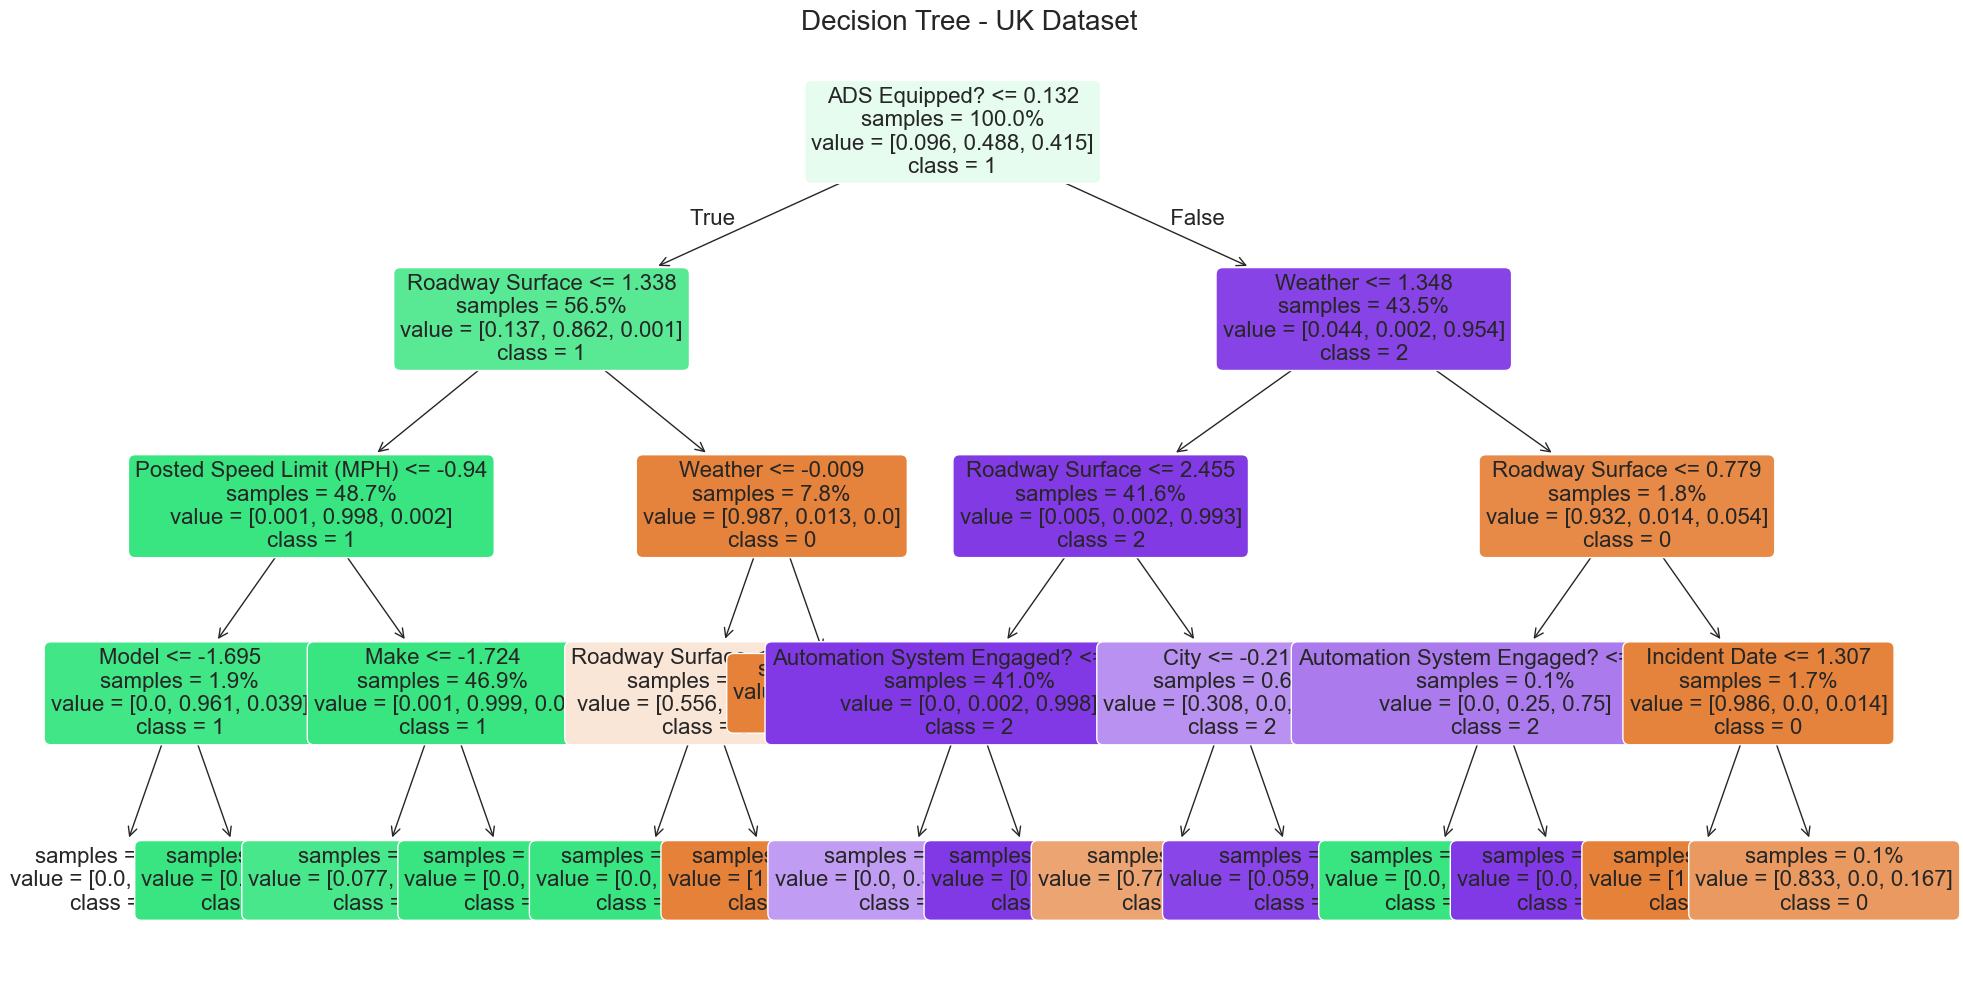

In [64]:
uk_params = { # the best parameters found
    "n_clusters": 3,
    "init": "k-means++",
    "max_iter": 500,
    "n_init": 15
}

uk_results = run_kmeans_with_explainability(us_encoded, "UK Dataset", uk_params)


**Final Cluster Run of the US dataset**

Best Parameters: {'n_clusters': 3, 'init': 'random', 'max_iter': 400, 'n_init': 20}
Silhouette Score: 0.219
Cluster Counts: {0: 1970, 1: 1674, 2: 388}

Training Decision Tree for Explainability...

Feature Importances:
ADS Equipped?: 0.7058
Roadway Surface: 0.2340
Weather: 0.0547
City: 0.0026
Model: 0.0018
Automation System Engaged?: 0.0009
Incident Date: 0.0001
Posted Speed Limit (MPH): 0.0001
Make: 0.0000
Model Year: 0.0000
Incident Time (24:00): 0.0000
State: 0.0000
Roadway Type: 0.0000
Lighting: 0.0000
Crash With: 0.0000
Highest Injury Severity Alleged: 0.0000
SV Pre-Crash Movement: 0.0000
SV Contact Area: 0.0000
Country: 0.0000


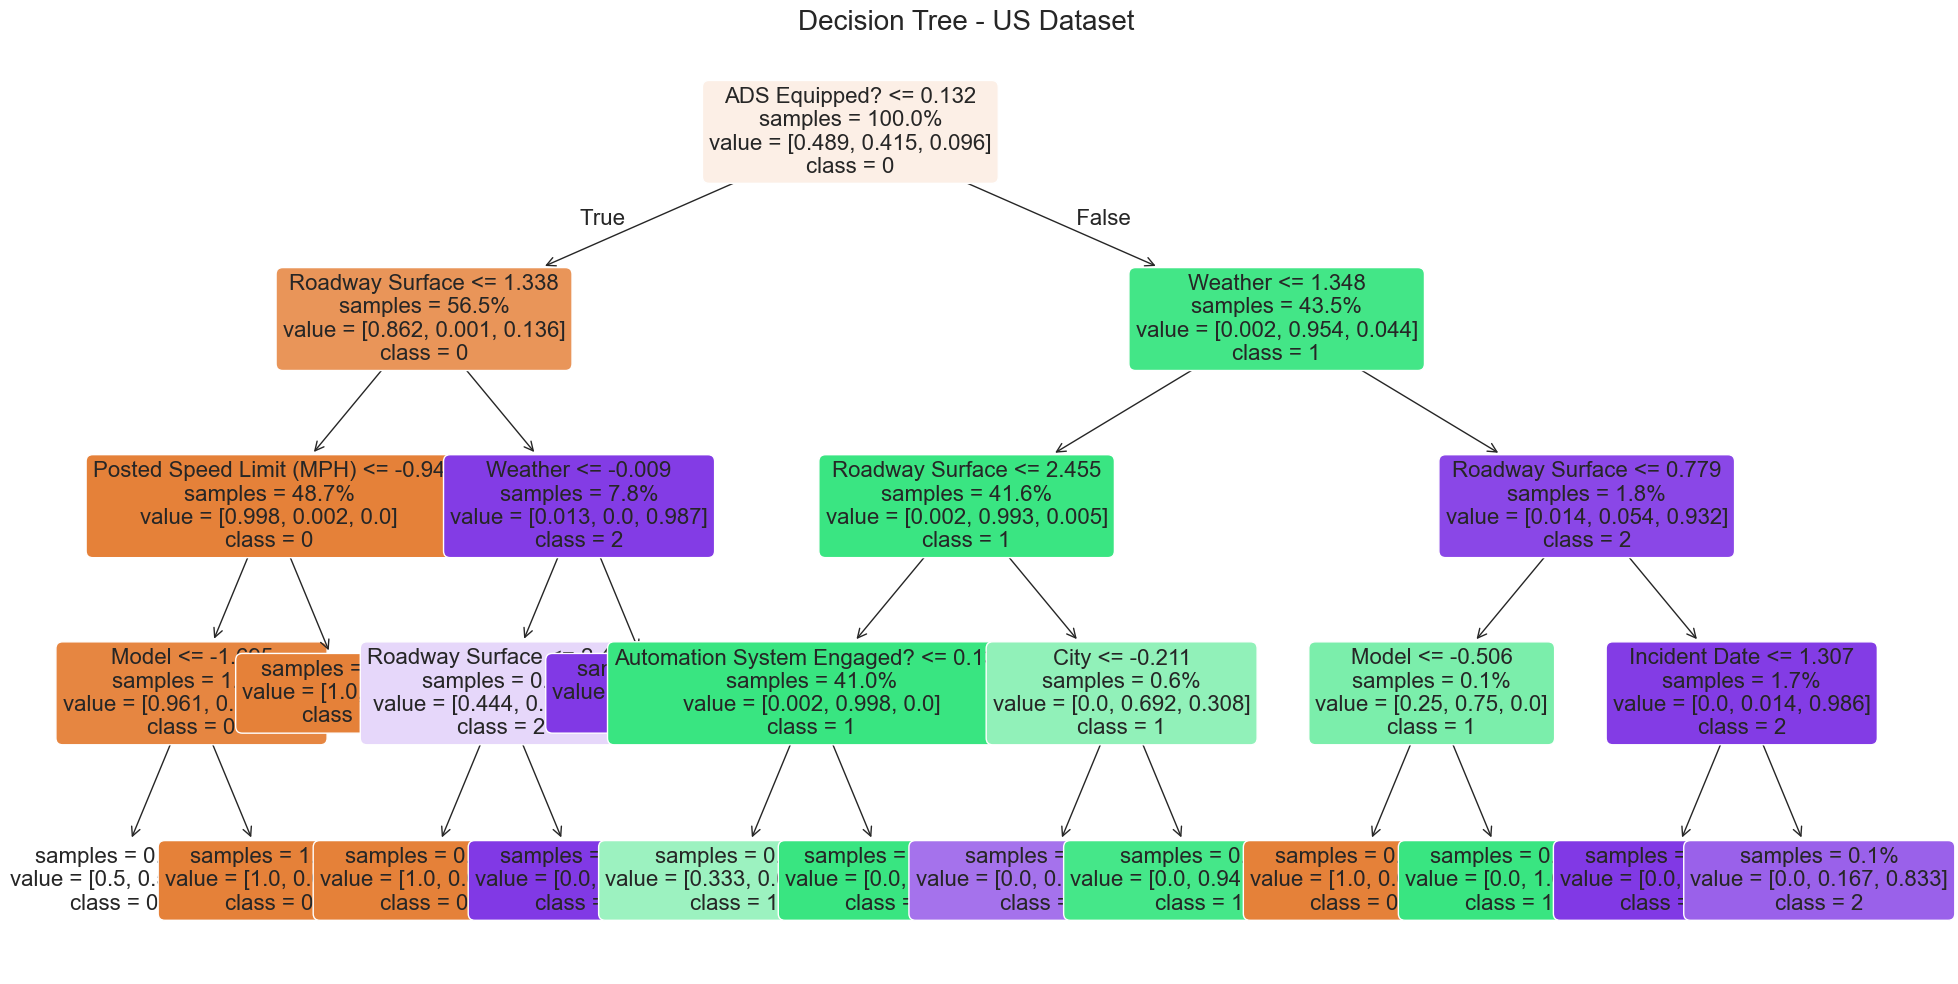

In [65]:
us_params = { # the best parameters found
    "n_clusters": 3,
    "init": "random",
    "max_iter": 400,
    "n_init": 20
}

us_results = run_kmeans_with_explainability(us_encoded, "US Dataset", us_params)


## **<span style="color:blue;">Section 5: PCA and TSNE</span>**

In [69]:
def run_kmeans_with_explainability_and_plots(X, dataset_name, params, run_decision_tree=True, plot_tree_flag=True):
    """
    Process: 
    Reference:
    - 2D PCA: https://plotly.com/python/pca-visualization/
    - 2D TSNE: https://www.datacamp.com/tutorial/introduction-t-sne
    - 3D TSNE: https://www.kaggle.com/code/rishidamarla/2d-3d-pca-t-sne-and-umap-on-wine-dataset
    """

    # run k maeans and store eval variables
    kmeans = KMeans(random_state=42, **params)
    labels = kmeans.fit_predict(X)
    sil = silhouette_score(X, labels)
    unique, counts = np.unique(labels, return_counts=True)
    cluster_counts = dict(zip(unique, counts))
    print(f"Silhouette Score: {sil:.3f}")
    print(f"Cluster Counts: {cluster_counts}")
    
    # PCA 2D Plot
    print("Plotting PCA 2D")
    pca_2d = PCA(n_components=2, random_state=42).fit_transform(X)
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=pca_2d[:, 0], y=pca_2d[:, 1], hue=labels, palette="viridis", s=50)
    plt.title(f"PCA 2D - {dataset_name}")
    plt.show()

    # PCA 3D Plot
    print("Plotting PCA 3D")
    pca_3d = PCA(n_components=3, random_state=42).fit_transform(X)
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(
        pca_3d[:, 0], pca_3d[:, 1], pca_3d[:, 2],
        c=labels, cmap='viridis', s=50
    )
    ax.set_title(f"PCA 3D - {dataset_name}", fontsize=14)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    fig.colorbar(scatter, ax=ax, label="Cluster")
    plt.show()

    
    # t-SNE 2D Plot
    print("Plotting t-SNE 2D")
    tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000).fit_transform(X)
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=tsne_2d[:, 0], y=tsne_2d[:, 1], hue=labels, palette="magma", s=50)
    plt.title(f"t-SNE 2D - {dataset_name}")
    plt.show()
    
    # t-SNE 3D Plot
    print("Plotting t-SNE 3D")
    tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=1000).fit_transform(X)
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(tsne_3d[:, 0], tsne_3d[:, 1], tsne_3d[:, 2], c=labels, cmap='magma', s=50)
    ax.set_title(f"t-SNE 3D - {dataset_name}")
    fig.colorbar(scatter)
    plt.show()
    
    return {
        "model": kmeans,
        "labels": labels,
        "silhouette": sil,
        "cluster_counts": cluster_counts
    }



Silhouette Score: 0.219
Cluster Counts: {0: 1970, 1: 1674, 2: 388}
Plotting PCA 2D


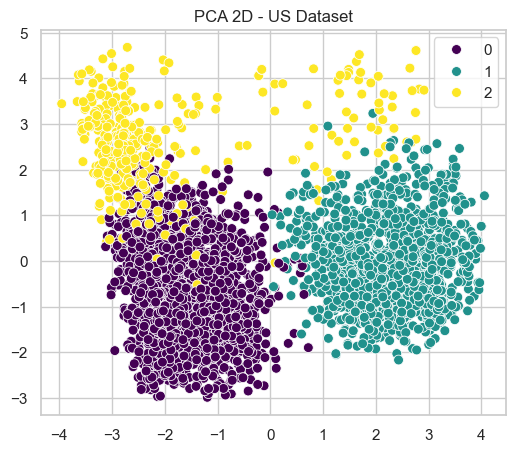

Plotting PCA 3D


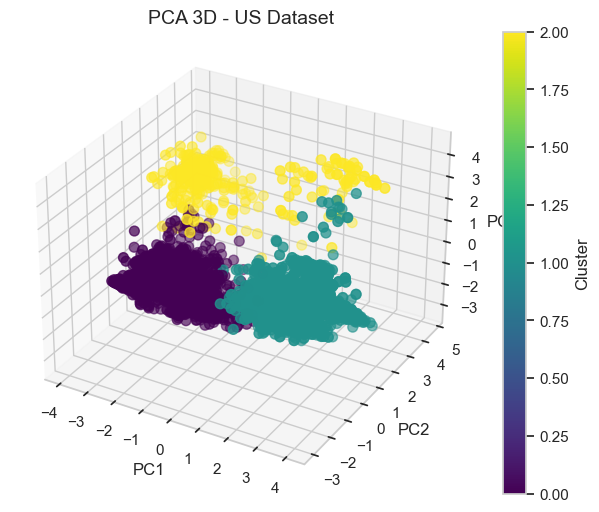

Plotting t-SNE 2D


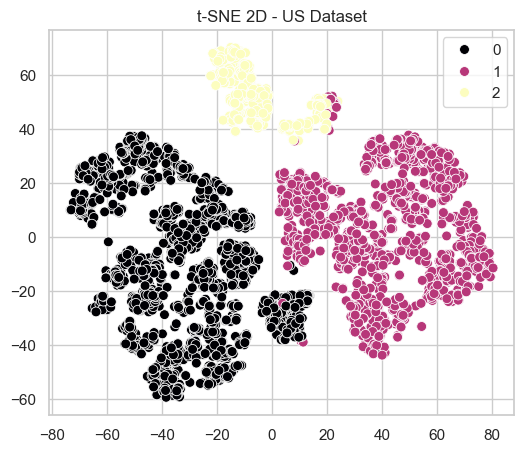

Plotting t-SNE 3D


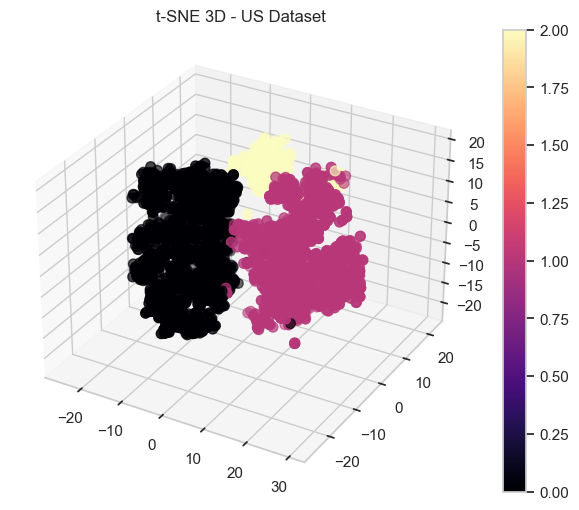

In [70]:
# US Dataset
us_results = run_kmeans_with_explainability_and_plots(us_encoded, "US Dataset", us_params)


Silhouette Score: 0.114
Cluster Counts: {0: 4656, 1: 4734, 2: 13589}
Plotting PCA 2D


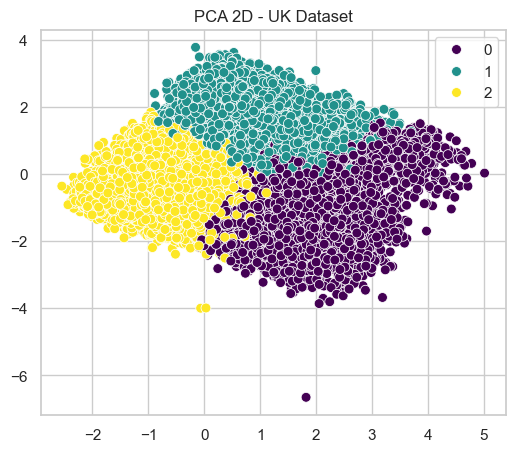

Plotting PCA 3D


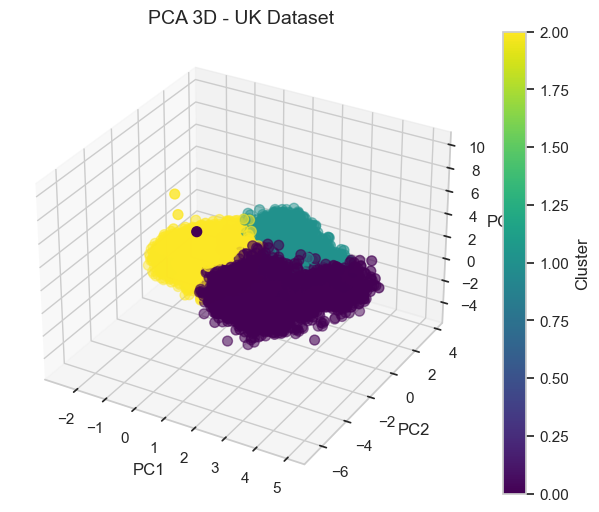

Plotting t-SNE 2D


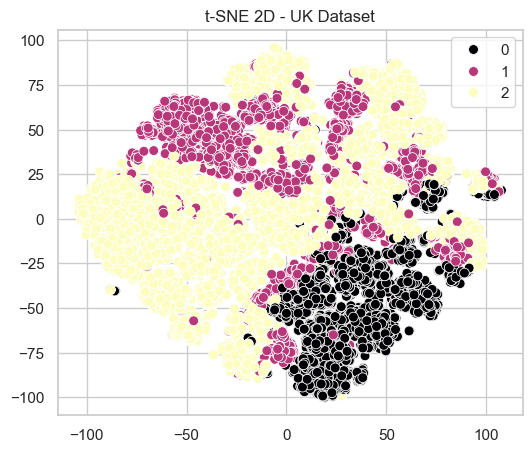

Plotting t-SNE 3D


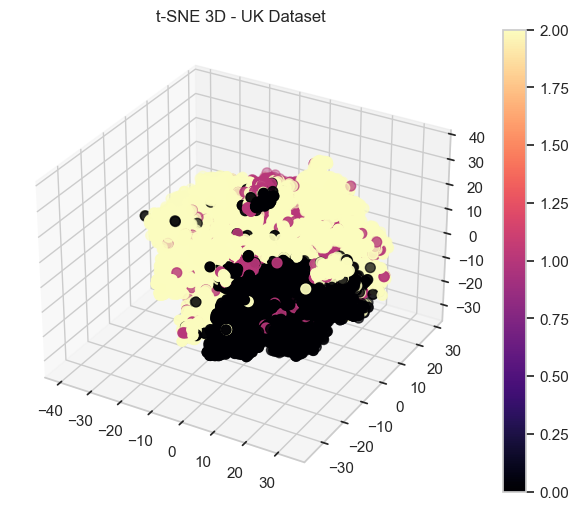

In [71]:
# UK Dataset
uk_results = run_kmeans_with_explainability_and_plots(uk_encoded, "UK Dataset", uk_params)

## **<span style="color:blue;">Section 6: Cluster Labelling</span>**

**Cluster Labelling**

In [72]:
def cluster_profiling(X, labels, max_cat_levels=8, top_n=10, plot=True, palette_name="pastel"):
    """
    Process: Mode table of the clusters and plots for the columns to visually see patterns
    References:
    -
    -
    -
    -
    """
    # make copy and new dictionaries of the clusters
    df = X.copy()
    df["Cluster"] = labels
    profile = {} #df with all the values for plotting and table
    variation_scores = {} # how much each feature is different from the ther clusters
    
    # PASTEL for all the colours and consistent
    unique_clusters = sorted(df["Cluster"].unique())
    cluster_palette = sns.color_palette(palette_name, n_colors=len(unique_clusters))
    
    # table
    for col in df.columns:
        if col == "Cluster": # dont break the loop if lcuter col!!!
            continue 
        if df[col].dtype in ["object", "category"] or df[col].nunique() <= max_cat_levels:
            mode_per_cluster = df.groupby("Cluster")[col].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
            profile[col] = mode_per_cluster
            # frequency table of each fluster and stores the variation and modes
            freq_table = pd.crosstab(df["Cluster"], df[col], normalize="index")
            variation_scores[col] = freq_table.var(axis=1).mean()
        else: # if numericaql col then get the mean (posted speed limit)
            mean_per_cluster = df.groupby("Cluster")[col].mean()
            profile[col] = mean_per_cluster
            
            variation_scores[col] = mean_per_cluster.var()
    profile_df = pd.DataFrame(profile)
    display(profile_df)
    top_features = sorted(variation_scores, key=variation_scores.get, reverse=True)[:top_n] # top features/vals cuz too busy
    
    # plot
    if plot:
        sns.set_style("whitegrid")
        for col in top_features:
            plt.figure(figsize=(6, 4))
            if df[col].dtype in ["object", "category"] or df[col].nunique() <= max_cat_levels:
                sns.countplot(data=df, x=col, hue="Cluster", palette=cluster_palette)
                plt.xticks(rotation=45)
            else:
                sns.boxplot(data=df, x="Cluster", y=col, palette=cluster_palette)
            plt.title(f"{col} distribution by cluster", fontsize=12, fontweight="bold")
            plt.xlabel(col, fontsize=10)
            plt.ylabel("Count" if df[col].dtype in ["object", "category"] else "Value", fontsize=10)
            plt.tight_layout()
            plt.show()
    
    return profile_df



,Make,Model,Model Year,ADS Equipped?,Automation System Engaged?,Incident Date,Incident Time (24:00),City,State,Roadway Type,Roadway Surface,Posted Speed Limit (MPH),Lighting,Crash With,Highest Injury Severity Alleged,SV Pre-Crash Movement,Weather,SV Contact Area,Country
Cluster,,,,,,,,,,,,,,,,,,,
0,Tesla,Model 3,2021.252792,No,ADAS,2025-10-24,02:28:00,Los Angeles,CA,Highway / Freeway,Dry,53.208122,Daylight,Other Fixed Object,No Injuries Reported,Proceeding Straight,Clear,Front,US
1,Jaguar,I-Pace,2021.969534,Yes,ADS,2025-04-08,23:30:00,San Francisco,CA,Street,Dry,27.114695,Daylight,Passenger Car,No Injuries Reported,Stopped,Clear,Back,US
2,Tesla,Model Y,2021.270619,No,ADAS,2025-12-22,01:33:00,San Francisco,CA,Highway / Freeway,Wet,53.402062,Daylight,Other Fixed Object,No Injuries Reported,Proceeding Straight,"Cloudy, Rain",Front,US


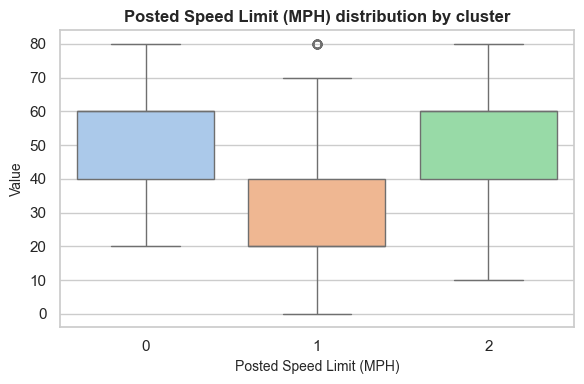

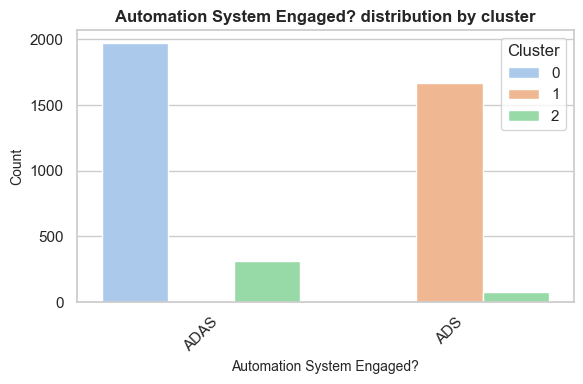

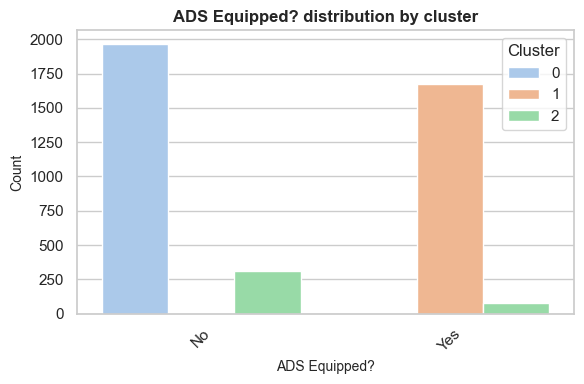

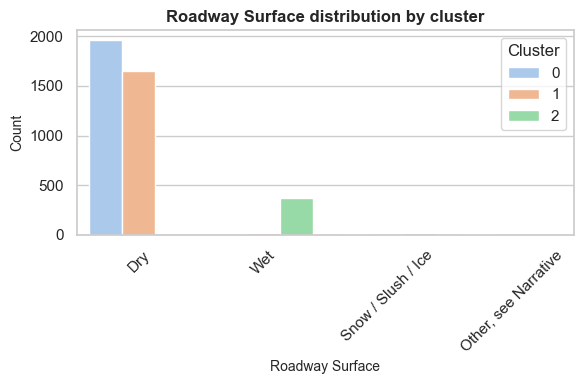

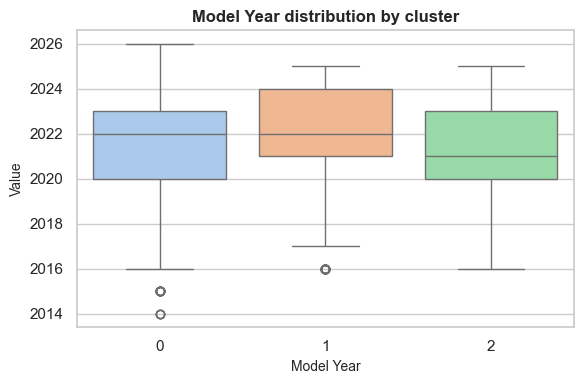

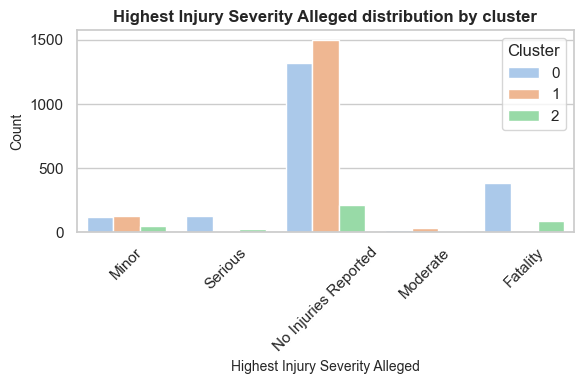

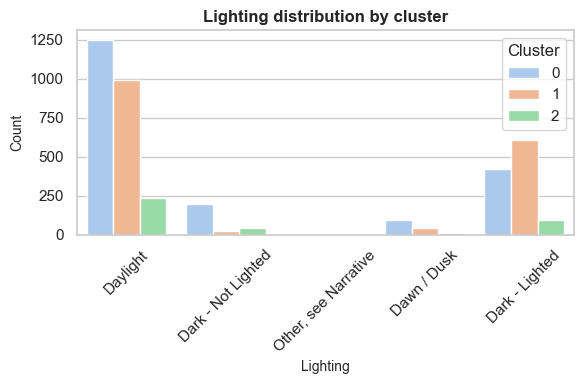

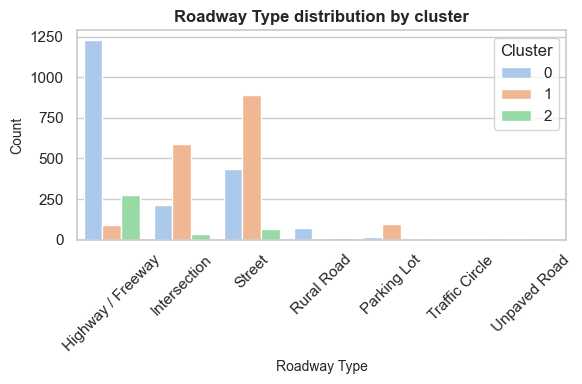

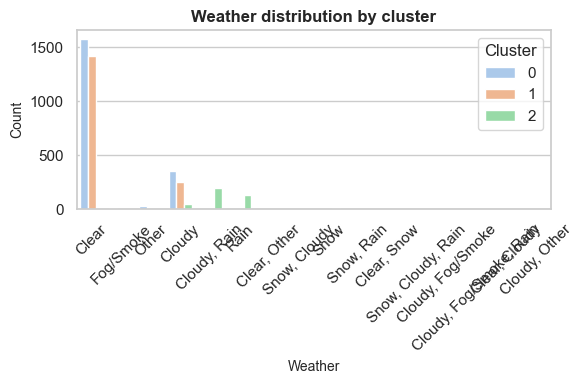

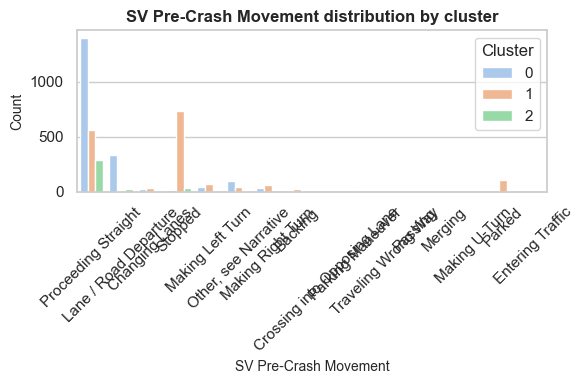

In [73]:
#US Dataset
cluster_summary = cluster_profiling(US_full, us_results["labels"])


,Make,Model,Model Year,ADS Equipped?,Automation System Engaged?,Incident Date,Incident Time (24:00),City,State,Roadway Type,Roadway Surface,Posted Speed Limit (MPH),Lighting,Crash With,Highest Injury Severity Alleged,SV Pre-Crash Movement,Weather,SV Contact Area,Country
Cluster,,,,,,,,,,,,,,,,,,,
0,FORD,FIESTA,2011.635095,Conventional,Conventional,2020-01-14,18:00:00,Birmingham,England,Single carriageway,Wet,30.0,Daylight,No Object,Minor,Going ahead other,Raining no high winds,Front,United Kingdom
1,FORD,FIESTA,2010.525349,Conventional,Conventional,2019-04-10,16:00:00,Bradford,England,Single carriageway,Dry,30.0,Daylight,No Object,Minor,Going ahead other,Clear,Front,United Kingdom
2,BMW,A3,2012.348002,Conventional,Conventional,2019-03-28,17:00:00,Bradford,England,Single carriageway,Dry,30.0,Daylight,No Object,Minor,Going ahead other,Clear,Front,United Kingdom


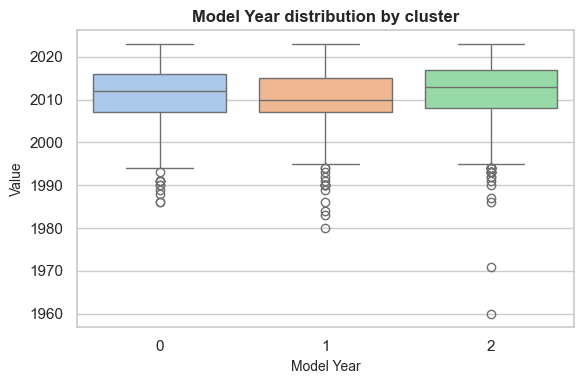

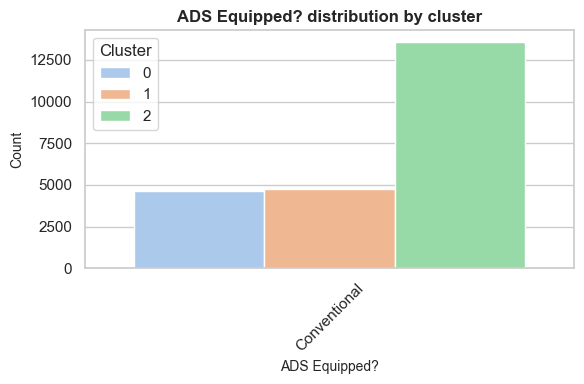

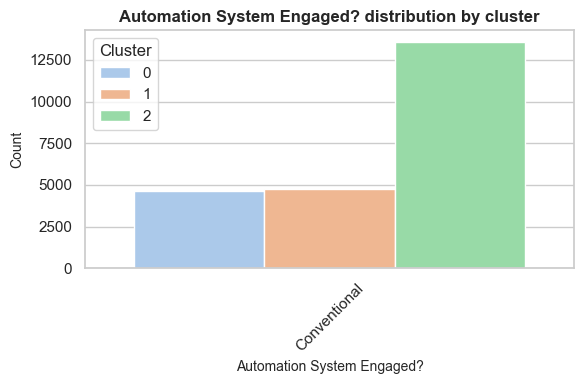

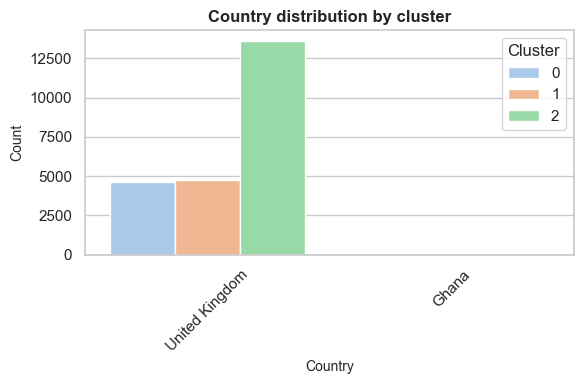

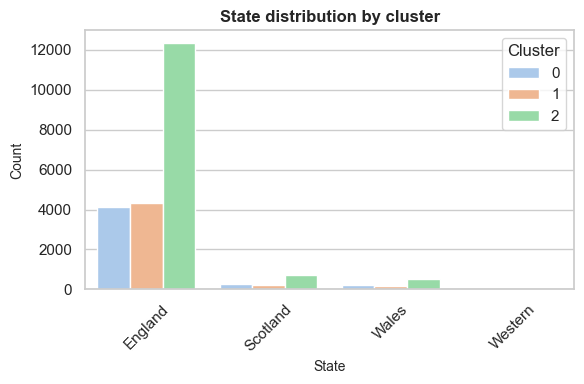

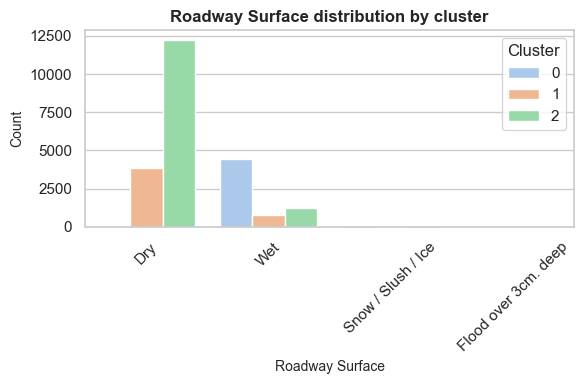

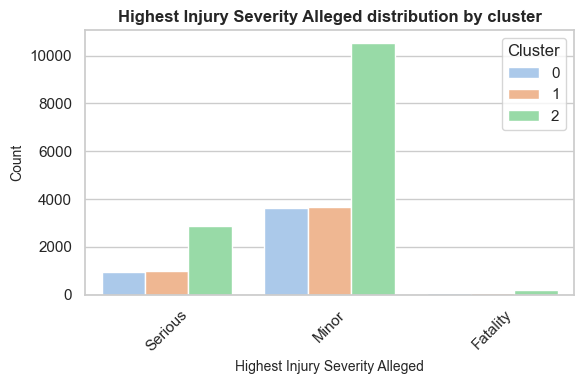

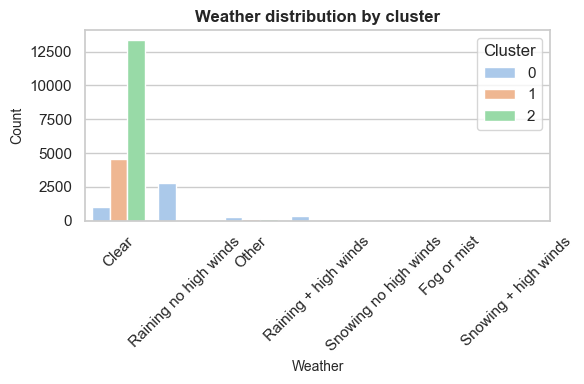

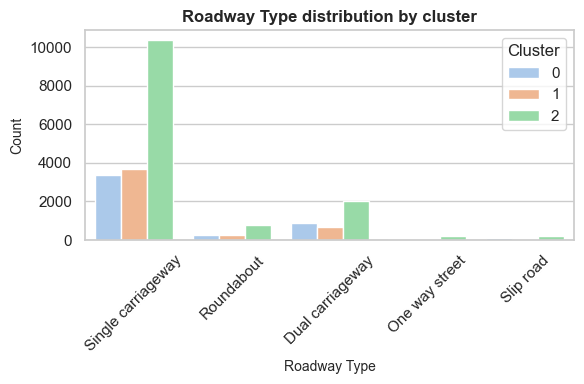

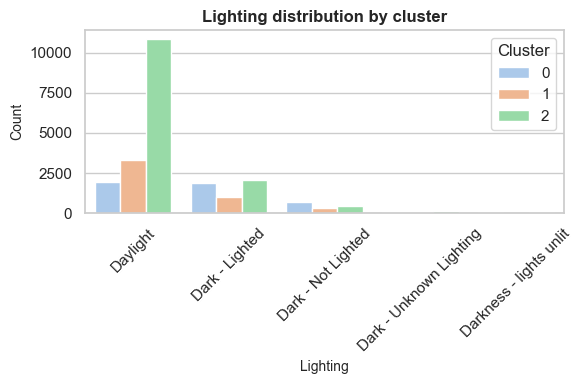

In [74]:
#UK Dataset
cluster_summary = cluster_profiling(UK_sampled, uk_results["labels"])